#Training a simple chatbot using a seq-to-seq model
# 1. Train and evaluate the chatbot model


Inspired by **Author:** [Matthew Inkawhich](https://github.com/MatthewInkawhich)


In this tutorial, we explore a fun and interesting use-case of recurrent
sequence-to-sequence models. We will train a simple chatbot using movie
scripts from the [Cornell Movie-Dialogs
Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html).

Conversational models are a hot topic in artificial intelligence
research. Chatbots can be found in a variety of settings, including
customer service applications and online helpdesks. These bots are often
powered by retrieval-based models, which output predefined responses to
questions of certain forms. In a highly restricted domain like a
company's IT helpdesk, these models may be sufficient, however, they are
not robust enough for more general use-cases. Teaching a machine to
carry out a meaningful conversation with a human in multiple domains is
a research question that is far from solved. Recently, the deep learning
boom has allowed for powerful generative models like Google's [Neural
Conversational Model](https://arxiv.org/abs/1506.05869), which marks a
large step towards multi-domain generative conversational models. In
this tutorial, we will implement this kind of model in PyTorch.

![](https://pytorch.org/tutorials/_static/img/chatbot/bot.png)

``` {.sourceCode .python}
> hello?
Bot: hello .
> where am I?
Bot: you re in a hospital .
> who are you?
Bot: i m a lawyer .
> how are you doing?
Bot: i m fine .
> are you my friend?
Bot: no .
> you're under arrest
Bot: i m trying to help you !
> i'm just kidding
Bot: i m sorry .
> where are you from?
Bot: san francisco .
> it's time for me to leave
Bot: i know .
> goodbye
Bot: goodbye .
```

**Tutorial Highlights**

-   Handle loading and preprocessing of [Cornell Movie-Dialogs
    Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)
    dataset
-   Implement a sequence-to-sequence model with [Luong attention
    mechanism(s)](https://arxiv.org/abs/1508.04025)
-   Jointly train encoder and decoder models using mini-batches
-   Implement greedy-search decoding module
-   Interact with trained chatbot

**Acknowledgments**

This tutorial borrows code from the following sources:

1)  Yuan-Kuei Wu's pytorch-chatbot implementation:
    <https://github.com/ywk991112/pytorch-chatbot>

2)  Sean Robertson's practical-pytorch seq2seq-translation example:
    <https://github.com/spro/practical-pytorch/tree/master/seq2seq-translation>
    
3)  FloydHub Cornell Movie Corpus preprocessing code:
    <https://github.com/floydhub/textutil-preprocess-cornell-movie-corpus>


##Preparations
To get started,
[download](https://zissou.infosci.cornell.edu/convokit/datasets/movie-corpus/movie-corpus.zip)
the Movie-Dialogs Corpus zip file.


In [ ]:
# and put in a ``data/`` directory under the current directory.
#
# After that, let’s import some necessities.
#

import torch
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import os
import unicodedata
import codecs
from io import open
import itertools
import math
import json


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [ ]:

device

device(type='cuda')

##Pretraining: Load & Preprocess Data
======================

The next step is to reformat our data file and load the data into
structures that we can work with.

The [Cornell Movie-Dialogs
Corpus](https://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html)
is a rich dataset of movie character dialog:

-   220,579 conversational exchanges between 10,292 pairs of movie
    characters
-   9,035 characters from 617 movies
-   304,713 total utterances

This dataset is large and diverse, and there is a great variation of
language formality, time periods, sentiment, etc. Our hope is that this
diversity makes our model robust to many forms of inputs and queries.

First, we'll take a look at some lines of our datafile to see the
original format.


In [ ]:
corpus_name = "movie-corpus"
# corpus = os.path.join("data", corpus_name)


# Samples of the file utterances.jsonl
def printLines(file, n=10):
    with open(file, 'rb') as datafile:
        lines = datafile.readlines()
    for line in lines[:n]:
        print(line)

printLines(os.path.join("", "/content/utterances.jsonl"))

b'{"id": "L1045", "conversation_id": "L1044", "text": "They do not!", "speaker": "u0", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "not", "tag": "RB", "dep": "neg", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": "L1044", "timestamp": null, "vectors": []}\n'
b'{"id": "L1044", "conversation_id": "L1044", "text": "They do to!", "speaker": "u2", "meta": {"movie_id": "m0", "parsed": [{"rt": 1, "toks": [{"tok": "They", "tag": "PRP", "dep": "nsubj", "up": 1, "dn": []}, {"tok": "do", "tag": "VBP", "dep": "ROOT", "dn": [0, 2, 3]}, {"tok": "to", "tag": "TO", "dep": "dobj", "up": 1, "dn": []}, {"tok": "!", "tag": ".", "dep": "punct", "up": 1, "dn": []}]}]}, "reply-to": null, "timestamp": null, "vectors": []}\n'
b'{"id": "L985", "conversation_id": "L984", "text": "I hope so.", "speaker": "u0", "meta": {

##Pretraining: Create formatted data file
For convenience, we\'ll create a nicely formatted data file in which
each line contains a tab-separated *query sentence* and a *response
sentence* pair.

The following functions facilitate the parsing of the raw
`utterances.jsonl` data file.

-   `loadLinesAndConversations` splits each line of the file into a
    dictionary of lines with fields: `lineID`, `characterID`, and text
    and then groups them into conversations with fields:
    `conversationID`, `movieID`, and lines.
-   `extractSentencePairs` extracts pairs of sentences from
    conversations


In [ ]:
# Splits each line of the file to create lines and conversations
def loadLinesAndConversations(fileName):
    lines = {}
    conversations = {}
    with open(fileName, 'r', encoding='iso-8859-1') as f:
        for line in f:
            lineJson = json.loads(line)
            # Extract fields for line object
            lineObj = {}
            lineObj["lineID"] = lineJson["id"]
            lineObj["characterID"] = lineJson["speaker"]
            lineObj["text"] = lineJson["text"]
            # save in the dictionary with key as lineID and value as the lineObj
            lines[lineObj['lineID']] = lineObj

            # Extract fields for conversation object
            if lineJson["conversation_id"] not in conversations:
                convObj = {}
                convObj["conversationID"] = lineJson["conversation_id"]
                convObj["movieID"] = lineJson["meta"]["movie_id"]
                convObj["lines"] = [lineObj]
            else:
                convObj = conversations[lineJson["conversation_id"]]
                convObj["lines"].insert(0, lineObj)
            conversations[convObj["conversationID"]] = convObj

    return lines, conversations


# Extracts pairs of sentences from conversations
def extractSentencePairs(conversations):
    qa_pairs = []
    for conversation in conversations.values():
        # Iterate over all the lines of the conversation
        for i in range(len(conversation["lines"]) - 1):  # We ignore the last line (no answer for it)
            inputLine = conversation["lines"][i]["text"].strip()
            targetLine = conversation["lines"][i+1]["text"].strip()
            # Filter wrong samples (if one of the lists is empty)
            if inputLine and targetLine:
                qa_pairs.append([inputLine, targetLine])
    return qa_pairs

Now we'll call these functions and create the file. We'll call it
`formatted_movie_lines.txt`.


In [ ]:
# Define path to new file
datafile = os.path.join("", "/content/formatted_movie_lines.txt")

delimiter = '\t'
# Unescape the delimiter
delimiter = str(codecs.decode(delimiter, "unicode_escape"))

# Initialize lines dict and conversations dict
lines = {}
conversations = {}
# Load lines and conversations
print("\nProcessing corpus into lines and conversations...")
lines, conversations = loadLinesAndConversations(os.path.join("", "/content/utterances.jsonl"))

# Write new csv file
print("\nWriting newly formatted file...")
with open(datafile, 'w', encoding='utf-8') as outputfile:
    writer = csv.writer(outputfile, delimiter=delimiter, lineterminator='\n')
    for pair in extractSentencePairs(conversations):
        writer.writerow(pair)

# Print a sample of lines
print("\nSample lines from file:")
printLines(datafile)


Processing corpus into lines and conversations...

Writing newly formatted file...

Sample lines from file:
b'They do to!\tThey do not!\n'
b'She okay?\tI hope so.\n'
b"Wow\tLet's go.\n"
b'"I\'m kidding.  You know how sometimes you just become this ""persona""?  And you don\'t know how to quit?"\tNo\n'
b"No\tOkay -- you're gonna need to learn how to lie.\n"
b"I figured you'd get to the good stuff eventually.\tWhat good stuff?\n"
b'What good stuff?\t"The ""real you""."\n'
b'"The ""real you""."\tLike my fear of wearing pastels?\n'
b'do you listen to this crap?\tWhat crap?\n'
b"What crap?\tMe.  This endless ...blonde babble. I'm like, boring myself.\n"


##Pretraining: Load and trim data

Our next order of business is to create a vocabulary and load
query/response sentence pairs into memory.

Note that we are dealing with sequences of **words**, which do not have
an implicit mapping to a discrete numerical space. Thus, we must create
one by mapping each unique word that we encounter in our dataset to an
index value.

For this we define a `Voc` class, which keeps a mapping from words to
indexes, a reverse mapping of indexes to words, a count of each word and
a total word count. The class provides methods for adding a word to the
vocabulary (`addWord`), adding all words in a sentence (`addSentence`)
and trimming infrequently seen words (`trim`). More on trimming later.


In [ ]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Voc:
    def __init__(self, name):
        self.name = name
        self.trimmed = False
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold
    def trim(self, min_count):
        if self.trimmed:
            return
        self.trimmed = True

        keep_words = []

        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)

        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))

        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

Now we can assemble our vocabulary and query/response sentence pairs.
Before we are ready to use this data, we must perform some
preprocessing.

First, we must convert the Unicode strings to ASCII using
`unicodeToAscii`. Next, we should convert all letters to lowercase and
trim all non-letter characters except for basic punctuation
(`normalizeString`). Finally, to aid in training convergence, we will
filter out sentences with length greater than the `MAX_LENGTH` threshold
(`filterPairs`).


In [ ]:
MAX_LENGTH = 10  # Maximum sentence length to consider

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# Read query/response pairs and return a voc object
def readVocs(datafile, corpus_name):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(datafile, encoding='utf-8').\
        read().strip().split('\n')
    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    voc = Voc(corpus_name)
    return voc, pairs

# Returns True if both sentences in a pair 'p' are under the MAX_LENGTH threshold
def filterPair(p):
    # Input sequences need to preserve the last word for EOS token
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

# Filter pairs using the ``filterPair`` condition
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Using the functions defined above, return a populated voc object and pairs list
def loadPrepareData(corpus, corpus_name, datafile, save_dir):
    print("Start preparing training data ...")
    voc, pairs = readVocs(datafile, corpus_name)
    print("Read {!s} sentence pairs".format(len(pairs)))
    pairs = filterPairs(pairs)
    print("Trimmed to {!s} sentence pairs".format(len(pairs)))
    print("Counting words...")
    for pair in pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
    print("Counted words:", voc.num_words)
    return voc, pairs


# Load/Assemble voc and pairs
save_dir = os.path.join("data", "save")
voc, pairs = loadPrepareData("", "", datafile, save_dir)
# Print some pairs to validate
print("\npairs:")
for pair in pairs[:10]:
    print(pair)

Start preparing training data ...
Reading lines...
Read 221282 sentence pairs
Trimmed to 64313 sentence pairs
Counting words...
Counted words: 18082

pairs:
['they do to !', 'they do not !']
['she okay ?', 'i hope so .']
['wow', 'let s go .']
['what good stuff ?', 'the real you .']
['the real you .', 'like my fear of wearing pastels ?']
['do you listen to this crap ?', 'what crap ?']
['well no . . .', 'then that s all you had to say .']
['then that s all you had to say .', 'but']
['but', 'you always been this selfish ?']
['have fun tonight ?', 'tons']


Another tactic that is beneficial to achieving faster convergence during
training is trimming rarely used words out of our vocabulary. Decreasing
the feature space will also soften the difficulty of the function that
the model must learn to approximate. We will do this as a two-step
process:

1)  Trim words used under `MIN_COUNT` threshold using the `voc.trim`
    function.
2)  Filter out pairs with trimmed words.


In [ ]:
MIN_COUNT = 3    # Minimum word count threshold for trimming

def trimRareWords(voc, pairs, MIN_COUNT):
    # Trim words used under the MIN_COUNT from the voc
    voc.trim(MIN_COUNT)
    # Filter out pairs with trimmed words
    keep_pairs = []
    for pair in pairs:
        input_sentence = pair[0]
        output_sentence = pair[1]
        keep_input = True
        keep_output = True
        # Check input sentence
        for word in input_sentence.split(' '):
            if word not in voc.word2index:
                keep_input = False
                break
        # Check output sentence
        for word in output_sentence.split(' '):
            if word not in voc.word2index:
                keep_output = False
                break

        # Only keep pairs that do not contain trimmed word(s) in their input or output sentence
        if keep_input and keep_output:
            keep_pairs.append(pair)

    print("Trimmed from {} pairs to {}, {:.4f} of total".format(len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs)))
    return keep_pairs


# Trim voc and pairs
pairs = trimRareWords(voc, pairs, MIN_COUNT)

keep_words 7833 / 18079 = 0.4333
Trimmed from 64313 pairs to 53131, 0.8261 of total


## Processing: Prepare Data for Models

Although we have put a great deal of effort into preparing and massaging
our data into a nice vocabulary object and list of sentence pairs, our
models will ultimately expect numerical torch tensors as inputs. One way
to prepare the processed data for the models can be found in the
[seq2seq translation
tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html).
In that tutorial, we use a batch size of 1, meaning that all we have to
do is convert the words in our sentence pairs to their corresponding
indexes from the vocabulary and feed this to the models.

However, if you're interested in speeding up training and/or would like
to leverage GPU parallelization capabilities, you will need to train
with mini-batches.

Using mini-batches also means that we must be mindful of the variation
of sentence length in our batches. To accommodate sentences of different
sizes in the same batch, we will make our batched input tensor of shape
*(max\_length, batch\_size)*, where sentences shorter than the
*max\_length* are zero padded after an *EOS\_token*.

If we simply convert our English sentences to tensors by converting
words to their indexes(`indexesFromSentence`) and zero-pad, our tensor
would have shape *(batch\_size, max\_length)* and indexing the first
dimension would return a full sequence across all time-steps. However,
we need to be able to index our batch along time, and across all
sequences in the batch. Therefore, we transpose our input batch shape to
*(max\_length, batch\_size)*, so that indexing across the first
dimension returns a time step across all sentences in the batch. We
handle this transpose implicitly in the `zeroPadding` function.

![](https://pytorch.org/tutorials/_static/img/chatbot/seq2seq_batches.png){.align-center}

The `inputVar` function handles the process of converting sentences to
tensor, ultimately creating a correctly shaped zero-padded tensor. It
also returns a tensor of `lengths` for each of the sequences in the
batch which will be passed to our decoder later.

The `outputVar` function performs a similar function to `inputVar`, but
instead of returning a `lengths` tensor, it returns a binary mask tensor
and a maximum target sentence length. The binary mask tensor has the
same shape as the output target tensor, but every element that is a
*PAD\_token* is 0 and all others are 1.

`batch2TrainData` simply takes a bunch of pairs and returns the input
and target tensors using the aforementioned functions.


In [ ]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


def zeroPadding(l, fillvalue=PAD_token):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

def binaryMatrix(l, value=PAD_token):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

# Returns padded input sequence tensor and lengths
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.BoolTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len


# Example for validation
small_batch_size = 5
batches = batch2TrainData(voc, [random.choice(pairs) for _ in range(small_batch_size)])
input_variable, lengths, target_variable, mask, max_target_len = batches

print("input_variable:", input_variable)
print("lengths:", lengths)
print("target_variable:", target_variable)
print("mask:", mask)
print("max_target_len:", max_target_len)

input_variable: tensor([[ 85,  11,  75,  34, 552],
        [ 17,  48, 109, 279,  10],
        [329, 994,  24,  14,   2],
        [ 14,   6,  10,   2,   0],
        [ 14,   2,   2,   0,   0],
        [ 14,   0,   0,   0,   0],
        [ 14,   0,   0,   0,   0],
        [  2,   0,   0,   0,   0]])
lengths: tensor([8, 5, 5, 4, 3])
target_variable: tensor([[   4,   85,  781,  162,  552],
        [  11,   17,    6,   14,   14],
        [ 419,   62,   11,    2,    2],
        [  62,  192,  200,    0,    0],
        [ 590, 1125,   62,    0,    0],
        [  10,  101,  235,    0,    0],
        [   2,   72,    6,    0,    0],
        [   0,   14,    2,    0,    0],
        [   0,    2,    0,    0,    0]])
mask: tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True, False, False],
        [ True,  True,  True, False, False],
        [ True,  True,  True, False, False],
        [ True, 

## Model: Define Models

Seq2Seq Model
-------------

The brains of our chatbot is a sequence-to-sequence (seq2seq) model. The
goal of a seq2seq model is to take a variable-length sequence as an
input, and return a variable-length sequence as an output using a
fixed-sized model.

[Sutskever et al.](https://arxiv.org/abs/1409.3215) discovered that by
using two separate recurrent neural nets together, we can accomplish
this task. One RNN acts as an **encoder**, which encodes a variable
length input sequence to a fixed-length context vector. In theory, this
context vector (the final hidden layer of the RNN) will contain semantic
information about the query sentence that is input to the bot. The
second RNN is a **decoder**, which takes an input word and the context
vector, and returns a guess for the next word in the sequence and a
hidden state to use in the next iteration.

![](https://pytorch.org/tutorials/_static/img/chatbot/seq2seq_ts.png){.align-center}

Image source:
<https://jeddy92.github.io/JEddy92.github.io/ts_seq2seq_intro/>


##Model: Encoder

The encoder RNN iterates through the input sentence one token
(e.g. word) at a time, at each time step outputting an "output" vector
and a "hidden state" vector. The hidden state vector is then passed to
the next time step, while the output vector is recorded. The encoder
transforms the context it saw at each point in the sequence into a set
of points in a high-dimensional space, which the decoder will use to
generate a meaningful output for the given task.

At the heart of our encoder is a multi-layered Gated Recurrent Unit,
invented by [Cho et al.](https://arxiv.org/pdf/1406.1078v3.pdf) in 2014.
We will use a bidirectional variant of the GRU, meaning that there are
essentially two independent RNNs: one that is fed the input sequence in
normal sequential order, and one that is fed the input sequence in
reverse order. The outputs of each network are summed at each time step.
Using a bidirectional GRU will give us the advantage of encoding both
past and future contexts.

Bidirectional RNN:

![](https://pytorch.org/tutorials/_static/img/chatbot/RNN-bidirectional.png){.align-center
width="70.0%"}

Image source: <https://colah.github.io/posts/2015-09-NN-Types-FP/>

Note that an `embedding` layer is used to encode our word indices in an
arbitrarily sized feature space. For our models, this layer will map
each word to a feature space of size *hidden\_size*. When trained, these
values should encode semantic similarity between similar meaning words.

Finally, if passing a padded batch of sequences to an RNN module, we
must pack and unpack padding around the RNN pass using
`nn.utils.rnn.pack_padded_sequence` and
`nn.utils.rnn.pad_packed_sequence` respectively.

**Computation Graph:**

> 1)  Convert word indexes to embeddings.
> 2)  Pack padded batch of sequences for RNN module.
> 3)  Forward pass through GRU.
> 4)  Unpack padding.
> 5)  Sum bidirectional GRU outputs.
> 6)  Return output and final hidden state.

**Inputs:**

-   `input_seq`: batch of input sentences; shape=*(max\_length,
    batch\_size)*
-   `input_lengths`: list of sentence lengths corresponding to each
    sentence in the batch; shape=*(batch\_size)*
-   `hidden`: hidden state; shape=*(n\_layers x num\_directions,
    batch\_size, hidden\_size)*

**Outputs:**

-   `outputs`: output features from the last hidden layer of the GRU
    (sum of bidirectional outputs); shape=*(max\_length, batch\_size,
    hidden\_size)*
-   `hidden`: updated hidden state from GRU; shape=*(n\_layers x
    num\_directions, batch\_size, hidden\_size)*


In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size parameters are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

##Model: Decoder

The decoder RNN generates the response sentence in a token-by-token
fashion. It uses the encoder's context vectors, and internal hidden
states to generate the next word in the sequence. It continues
generating words until it outputs an *EOS\_token*, representing the end
of the sentence. A common problem with a vanilla seq2seq decoder is that
if we rely solely on the context vector to encode the entire input
sequence's meaning, it is likely that we will have information loss.
This is especially the case when dealing with long input sequences,
greatly limiting the capability of our decoder.

To combat this, [Bahdanau et al.](https://arxiv.org/abs/1409.0473)
created an "attention mechanism" that allows the decoder to pay
attention to certain parts of the input sequence, rather than using the
entire fixed context at every step.

At a high level, attention is calculated using the decoder's current
hidden state and the encoder's outputs. The output attention weights
have the same shape as the input sequence, allowing us to multiply them
by the encoder outputs, giving us a weighted sum which indicates the
parts of encoder output to pay attention to. [Sean
Robertson's](https://github.com/spro) figure describes this very well:

![](https://pytorch.org/tutorials/_static/img/chatbot/attn2.png){.align-center}

[Luong et al.](https://arxiv.org/abs/1508.04025) improved upon Bahdanau
et al.'s groundwork by creating "Global attention". The key difference
is that with "Global attention", we consider all of the encoder's hidden
states, as opposed to Bahdanau et al.'s "Local attention", which only
considers the encoder's hidden state from the current time step. Another
difference is that with "Global attention", we calculate attention
weights, or energies, using the hidden state of the decoder from the
current time step only. Bahdanau et al.'s attention calculation requires
knowledge of the decoder's state from the previous time step. Also,
Luong et al. provides various methods to calculate the attention
energies between the encoder output and decoder output which are called
"score functions":

![](https://pytorch.org/tutorials/_static/img/chatbot/scores.png){.align-center
width="60.0%"}

where $h_t$ = current target decoder state and $\bar{h}_s$ = all encoder
states.

Overall, the Global attention mechanism can be summarized by the
following figure. Note that we will implement the "Attention Layer" as a
separate `nn.Module` called `Attn`. The output of this module is a
softmax normalized weights tensor of shape *(batch\_size, 1,
max\_length)*.

![](https://pytorch.org/tutorials/_static/img/chatbot/global_attn.png){.align-center
width="60.0%"}


In [ ]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

Now that we have defined our attention submodule, we can implement the
actual decoder model. For the decoder, we will manually feed our batch
one time step at a time. This means that our embedded word tensor and
GRU output will both have shape *(1, batch\_size, hidden\_size)*.

**Computation Graph:**

> 1)  Get embedding of current input word.
> 2)  Forward through unidirectional GRU.
> 3)  Calculate attention weights from the current GRU output from (2).
> 4)  Multiply attention weights to encoder outputs to get new
>     \"weighted sum\" context vector.
> 5)  Concatenate weighted context vector and GRU output using Luong
>     eq. 5.
> 6)  Predict next word using Luong eq. 6 (without softmax).
> 7)  Return output and final hidden state.

**Inputs:**

-   `input_step`: one time step (one word) of input sequence batch;
    shape=*(1, batch\_size)*
-   `last_hidden`: final hidden layer of GRU; shape=*(n\_layers x
    num\_directions, batch\_size, hidden\_size)*
-   `encoder_outputs`: encoder model's output; shape=*(max\_length,
    batch\_size, hidden\_size)*

**Outputs:**

-   `output`: softmax normalized tensor giving probabilities of each
    word being the correct next word in the decoded sequence;
    shape=*(batch\_size, voc.num\_words)*
-   `hidden`: final hidden state of GRU; shape=*(n\_layers x
    num\_directions, batch\_size, hidden\_size)*


In [ ]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)

    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

##Training: Define Training Procedure

Masked loss
-----------

Since we are dealing with batches of padded sequences, we cannot simply
consider all elements of the tensor when calculating loss. We define
`maskNLLLoss` to calculate our loss based on our decoder's output
tensor, the target tensor, and a binary mask tensor describing the
padding of the target tensor. This loss function calculates the average
negative log likelihood of the elements that correspond to a *1* in the
mask tensor.


In [ ]:
def maskNLLLoss(inp, target, mask):
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    loss = loss.to(device)
    return loss, nTotal.item()

##Training: Single training iteration

The `train` function contains the algorithm for a single training
iteration (a single batch of inputs).

We will use a couple of clever tricks to aid in convergence:

-   The first trick is using **teacher forcing**. This means that at
    some probability, set by `teacher_forcing_ratio`, we use the current
    target word as the decoder's next input rather than using the
    decoder's current guess. This technique acts as training wheels for
    the decoder, aiding in more efficient training. However, teacher
    forcing can lead to model instability during inference, as the
    decoder may not have a sufficient chance to truly craft its own
    output sequences during training. Thus, we must be mindful of how we
    are setting the `teacher_forcing_ratio`, and not be fooled by fast
    convergence.
-   The second trick that we implement is **gradient clipping**. This is
    a commonly used technique for countering the "exploding gradient"
    problem. In essence, by clipping or thresholding gradients to a
    maximum value, we prevent the gradients from growing exponentially
    and either overflow (NaN), or overshoot steep cliffs in the cost
    function.

![](https://pytorch.org/tutorials/_static/img/chatbot/grad_clip.png){.align-center
width="60.0%"}

Image source: Goodfellow et al. *Deep Learning*. 2016.
<https://www.deeplearningbook.org/>

**Sequence of Operations:**

> 1)  Forward pass entire input batch through encoder.
> 2)  Initialize decoder inputs as SOS\_token, and hidden state as the
>     encoder\'s final hidden state.
> 3)  Forward input batch sequence through decoder one time step at a
>     time.
> 4)  If teacher forcing: set next decoder input as the current target;
>     else: set next decoder input as current decoder output.
> 5)  Calculate and accumulate loss.
> 6)  Perform backpropagation.
> 7)  Clip gradients.
> 8)  Update encoder and decoder model parameters.


In [ ]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, max_length=MAX_LENGTH, teacher_forcing_ratio=1.0):

    # Zero gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Set device options
    input_variable = input_variable.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)
    # Lengths for RNN packing should always be on the CPU
    lengths = lengths.to("cpu")

    # Initialize variables
    loss = 0
    print_losses = []
    n_totals = 0

    # Forward pass through encoder
    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)

    # Create initial decoder input (start with SOS tokens for each sentence)
    decoder_input = torch.LongTensor([[SOS_token for _ in range(batch_size)]])
    decoder_input = decoder_input.to(device)

    # Set initial decoder hidden state to the encoder's final hidden state
    decoder_hidden = encoder_hidden[:decoder.n_layers]

    # Determine if we are using teacher forcing this iteration
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    # Forward batch of sequences through decoder one time step at a time
    if use_teacher_forcing:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # Teacher forcing: next input is current target
            decoder_input = target_variable[t].view(1, -1)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal
    else:
        for t in range(max_target_len):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            # No teacher forcing: next input is decoder's own current output
            _, topi = decoder_output.topk(1)
            decoder_input = torch.LongTensor([[topi[i][0] for i in range(batch_size)]])
            decoder_input = decoder_input.to(device)
            # Calculate and accumulate loss
            mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
            loss += mask_loss
            print_losses.append(mask_loss.item() * nTotal)
            n_totals += nTotal

    # Perform backpropagation
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()

    return sum(print_losses) / n_totals

##Training: Training iterations

It is finally time to tie the full training procedure together with the
data. The `trainIters` function is responsible for running
`n_iterations` of training given the passed models, optimizers, data,
etc. This function is quite self explanatory, as we have done the heavy
lifting with the `train` function.

One thing to note is that when we save our model, we save a tarball
containing the encoder and decoder `state_dicts` (parameters), the
optimizers' `state_dicts`, the loss, the iteration, etc. Saving the
model in this way will give us the ultimate flexibility with the
checkpoint. After loading a checkpoint, we will be able to use the model
parameters to run inference, or we can continue training right where we
left off.


In [ ]:
def trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer, embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size, print_every, save_every, clip, corpus_name, loadFilename, teacher_forcing_ratio):

    # Load batches for each iteration
    training_batches = [batch2TrainData(voc, [random.choice(pairs) for _ in range(batch_size)])
                      for _ in range(n_iteration)]

    # Initializations
    print('Initializing ...')
    start_iteration = 1
    print_loss = 0
    if loadFilename:
        start_iteration = checkpoint['iteration'] + 1

    # Training loop
    print("Training...")
    for iteration in range(start_iteration, n_iteration + 1):
        training_batch = training_batches[iteration - 1]
        # Extract fields from batch
        input_variable, lengths, target_variable, mask, max_target_len = training_batch

        # Run a training iteration with batch
        loss = train(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                     decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip, teacher_forcing_ratio)
        print_loss += loss

        # Print progress
        if iteration % print_every == 0:
            print_loss_avg = print_loss / print_every
            print("Iteration: {}; Percent complete: {:.1f}%; Average loss: {:.4f}".format(iteration, iteration / n_iteration * 100, print_loss_avg))
            print_loss = 0

        # Save checkpoint
        if (iteration % save_every == 0):
            directory = os.path.join(save_dir, model_name, corpus_name, '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size))
            print(directory)
            if not os.path.exists(directory):
                os.makedirs(directory)
            torch.save({
                'iteration': iteration,
                'en': encoder.state_dict(),
                'de': decoder.state_dict(),
                'en_opt': encoder_optimizer.state_dict(),
                'de_opt': decoder_optimizer.state_dict(),
                'loss': loss,
                'voc_dict': voc.__dict__,
                'embedding': embedding.state_dict()
            }, os.path.join(directory, '{}_{}.tar'.format(iteration, 'checkpoint')))

## Training: Define Evaluation

After training a model, we want to be able to talk to the bot ourselves.
First, we must define how we want the model to decode the encoded input.

Greedy decoding
---------------

Greedy decoding is the decoding method that we use during training when
we are **NOT** using teacher forcing. In other words, for each time
step, we simply choose the word from `decoder_output` with the highest
softmax value. This decoding method is optimal on a single time-step
level.

To facilitate the greedy decoding operation, we define a
`GreedySearchDecoder` class. When run, an object of this class takes an
input sequence (`input_seq`) of shape *(input\_seq length, 1)*, a scalar
input length (`input_length`) tensor, and a `max_length` to bound the
response sentence length. The input sentence is evaluated using the
following computational graph:

**Computation Graph:**

> 1)  Forward input through encoder model.
> 2)  Prepare encoder\'s final hidden layer to be first hidden input to
>     the decoder.
> 3)  Initialize decoder\'s first input as SOS\_token.
> 4)  Initialize tensors to append decoded words to.
> 5)  
>
>     Iteratively decode one word token at a time:
>
>     :   a)  Forward pass through decoder.
>         b)  Obtain most likely word token and its softmax score.
>         c)  Record token and score.
>         d)  Prepare current token to be next decoder input.
>
> 6)  Return collections of word tokens and scores.


In [ ]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores

##Training: Evaluate my text

Now that we have our decoding method defined, we can write functions for
evaluating a string input sentence. The `evaluate` function manages the
low-level process of handling the input sentence. We first format the
sentence as an input batch of word indexes with *batch\_size==1*. We do
this by converting the words of the sentence to their corresponding
indexes, and transposing the dimensions to prepare the tensor for our
models. We also create a `lengths` tensor which contains the length of
our input sentence. In this case, `lengths` is scalar because we are
only evaluating one sentence at a time (batch\_size==1). Next, we obtain
the decoded response sentence tensor using our `GreedySearchDecoder`
object (`searcher`). Finally, we convert the response's indexes to words
and return the list of decoded words.

`evaluateInput` acts as the user interface for our chatbot. When called,
an input text field will spawn in which we can enter our query sentence.
After typing our input sentence and pressing *Enter*, our text is
normalized in the same way as our training data, and is ultimately fed
to the `evaluate` function to obtain a decoded output sentence. We loop
this process, so we can keep chatting with our bot until we enter either
"q" or "quit".

Finally, if a sentence is entered that contains a word that is not in
the vocabulary, we handle this gracefully by printing an error message
and prompting the user to enter another sentence.


In [ ]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length=MAX_LENGTH):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to("cpu")
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words


def evaluateInput(encoder, decoder, searcher, voc):
    input_sentence = ''
    while(1):
        try:
            # Get input sentence
            input_sentence = input('> ')
            # Check if it is quit case
            if input_sentence == 'q' or input_sentence == 'quit': break
            # Normalize sentence
            input_sentence = normalizeString(input_sentence)
            # Evaluate sentence
            output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
            # Format and print response sentence
            output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
            print('Bot:', ' '.join(output_words))

        except KeyError:
            print("Error: Encountered unknown word.")

##Run Model

Finally, it is time to run our model!

Regardless of whether we want to train or test the chatbot model, we
must initialize the individual encoder and decoder models. In the
following block, we set our desired configurations, choose to start from
scratch or set a checkpoint to load from, and build and initialize the
models. Feel free to play with different model configurations to
optimize performance.


In [ ]:
# Configure models
model_name = 'cb_model'
attn_model = 'dot'
#``attn_model = 'general'``
#``attn_model = 'concat'``
hidden_size = 500
encoder_n_layers = 2
decoder_n_layers = 2
dropout = 0.1
batch_size = 64

# Set checkpoint to load from; set to None if starting from scratch
loadFilename = None
checkpoint_iter = 400

Sample code to load from a checkpoint:

``` {.sourceCode .python}
loadFilename = os.path.join(save_dir, model_name, corpus_name,
                    '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                    '{}_checkpoint.tar'.format(checkpoint_iter))
```


In [ ]:
# Load model if a ``loadFilename`` is provided
if loadFilename:
    # If loading on same machine the model was trained on
    #checkpoint = torch.load(loadFilename)
    # If loading a model trained on GPU to CPU
    checkpoint = torch.load(loadFilename)
    encoder_sd = checkpoint['en']
    decoder_sd = checkpoint['de']
    encoder_optimizer_sd = checkpoint['en_opt']
    decoder_optimizer_sd = checkpoint['de_opt']
    embedding_sd = checkpoint['embedding']
    voc.__dict__ = checkpoint['voc_dict']


print('Building encoder and decoder ...')
# Initialize word embeddings
embedding = nn.Embedding(voc.num_words, hidden_size)
if loadFilename:
    embedding.load_state_dict(embedding_sd)
# Initialize encoder & decoder models
encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
decoder = LuongAttnDecoderRNN(attn_model, embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
if loadFilename:
    encoder.load_state_dict(encoder_sd)
    decoder.load_state_dict(decoder_sd)
# Use appropriate device
encoder = encoder.to(device)
decoder = decoder.to(device)
print('Models built and ready to go!')

Building encoder and decoder ...
Models built and ready to go!


##Run Training

Run the following block if you want to train the model.

First we set training parameters, then we initialize our optimizers, and
finally we call the `trainIters` function to run our training
iterations.


In [ ]:
# Configure training/optimization
clip = 50.0
teacher_forcing_ratio = 1.0
learning_rate = 0.0001
decoder_learning_ratio = 5.0
n_iteration = 4000
print_every = 100
save_every = 500

# Ensure dropout layers are in train mode
encoder.train()
decoder.train()

# Initialize optimizers
print('Building optimizers ...')
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate * decoder_learning_ratio)
if loadFilename:
    encoder_optimizer.load_state_dict(encoder_optimizer_sd)
    decoder_optimizer.load_state_dict(decoder_optimizer_sd)

# If you have CUDA, configure CUDA to call
for state in encoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

for state in decoder_optimizer.state.values():
    for k, v in state.items():
        if isinstance(v, torch.Tensor):
            state[k] = v.cuda()

# Run training iterations
print("Starting Training!")
trainIters(model_name, voc, pairs, encoder, decoder, encoder_optimizer, decoder_optimizer,
           embedding, encoder_n_layers, decoder_n_layers, save_dir, n_iteration, batch_size,
           print_every, save_every, clip, corpus_name, loadFilename, teacher_forcing_ratio)

Building optimizers ...
Starting Training!
Initializing ...
Training...
Iteration: 100; Percent complete: 2.5%; Average loss: 5.0329
Iteration: 200; Percent complete: 5.0%; Average loss: 4.2242
Iteration: 300; Percent complete: 7.5%; Average loss: 3.9722
Iteration: 400; Percent complete: 10.0%; Average loss: 3.8573
Iteration: 500; Percent complete: 12.5%; Average loss: 3.7500
data/save/cb_model/movie-corpus/2-2_500
Iteration: 600; Percent complete: 15.0%; Average loss: 3.7139
Iteration: 700; Percent complete: 17.5%; Average loss: 3.6425
Iteration: 800; Percent complete: 20.0%; Average loss: 3.5903
Iteration: 900; Percent complete: 22.5%; Average loss: 3.5012
Iteration: 1000; Percent complete: 25.0%; Average loss: 3.4521
data/save/cb_model/movie-corpus/2-2_500
Iteration: 1100; Percent complete: 27.5%; Average loss: 3.4483
Iteration: 1200; Percent complete: 30.0%; Average loss: 3.3934
Iteration: 1300; Percent complete: 32.5%; Average loss: 3.3744
Iteration: 1400; Percent complete: 35.0%;

##Run Evaluation

To chat with your model, run the following block.


In [ ]:
# Set dropout layers to ``eval`` mode
encoder.eval()
decoder.eval()

# Initialize search module
searcher = GreedySearchDecoder(encoder, decoder)

# Begin chatting (uncomment and run the following line to begin)
evaluateInput(encoder, decoder, searcher, voc)
# Type q or quit to exit chatbot

> Hi
Bot: hi . . . . !
> How are you?
Bot: i m fine . . . !
> q


## 2. Create a sweep configuration using the using the W&B Random Search


### Install W&B and import the W&B Python SDK into your notebook:

1. Install with `!pip install`:

In [ ]:
!pip install wandb -Uq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.5 MB/s eta 0:00:00


2. Import W&B:

In [ ]:
import wandb

3. Log in to W&B and provide your API key when prompted:

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Define a sweep

In [ ]:
sweep_config = {
    'method': 'random'
    }

In [ ]:
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }

sweep_config['metric'] = metric

In [ ]:
parameters_dict = {
     'learning_rate': {
            'values': [0.0001, 0.00025, 0.0005, 0.001]  # Learning rate options
        },
        'optimizer': {
            'values': ['adam', 'sgd']  # Optimizer choices
        },
        'clip': {
            'values': [0, 25, 50, 100]  # Gradient clipping options
        },
        'teacher_forcing_ratio': {
            'values': [0, 0.5, 1.0]  # Teacher forcing ratio options
        },
        'decoder_learning_ratio': {
            'values': [1.0, 3.0, 5.0, 10.0]  # Decoder learning ratio options
        }
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'clip': {'values': [0, 25, 50, 100]},
                'decoder_learning_ratio': {'values': [1.0, 3.0, 5.0, 10.0]},
                'learning_rate': {'values': [0.0001, 0.00025, 0.0005, 0.001]},
                'optimizer': {'values': ['adam', 'sgd']},
                'teacher_forcing_ratio': {'values': [0, 0.5, 1.0]}}}


In [ ]:
# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="seq2seq-chatbot")

Create sweep with ID: c75gcr04
Sweep URL: https://wandb.ai/tg2936-columbia-university/seq2seq-chatbot/sweeps/c75gcr04


##Run your hyperparameter sweeps

Modify `train` function to support a W&B sweep

In [ ]:
def train_model_with_sweep():
    encoder.train()  # Set encoder to train mode
    decoder.train()
    wandb.init(project="seq2seq-chatbot")
    # Initialize the W&B config (these will be automatically set by the sweep agent)
    config = wandb.config

    # Select optimizer based on config
    if config.optimizer == 'adam':
        encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=config.learning_rate)
        decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=config.learning_rate * config.decoder_learning_ratio)
    elif config.optimizer == 'sgd':
        encoder_optimizer = torch.optim.SGD(encoder.parameters(), lr=config.learning_rate)
        decoder_optimizer = torch.optim.SGD(decoder.parameters(), lr=config.learning_rate * config.decoder_learning_ratio)

    # Run the training iterations with the W&B sweep parameters
    trainIters(
        model_name="chatbot",
        voc=voc,  # Assuming voc and pairs are defined elsewhere
        pairs=pairs,
        encoder=encoder,
        decoder=decoder,
        encoder_optimizer=encoder_optimizer,
        decoder_optimizer=decoder_optimizer,
        encoder_n_layers=encoder_n_layers,
        decoder_n_layers=decoder_n_layers,
        embedding=embedding,
        save_dir="save/",
        n_iteration=4000,  # You can change this if you want to sweep over iterations
        batch_size=64,
        print_every=10,
        save_every=1000,
        clip=config.clip,  # Use clipping from W&B sweep config
        teacher_forcing_ratio=config.teacher_forcing_ratio,  # Use teacher forcing from sweep config
        corpus_name="corpus",
        loadFilename=None
    )

# Run the W&B sweep
wandb.agent(sweep_id, function=train_model_with_sweep, count=6)


## Extract best hyperparameters & feature importance tool

The hyperparameter importance plot surfaces which hyperparameters were the best predictors of your metrics.

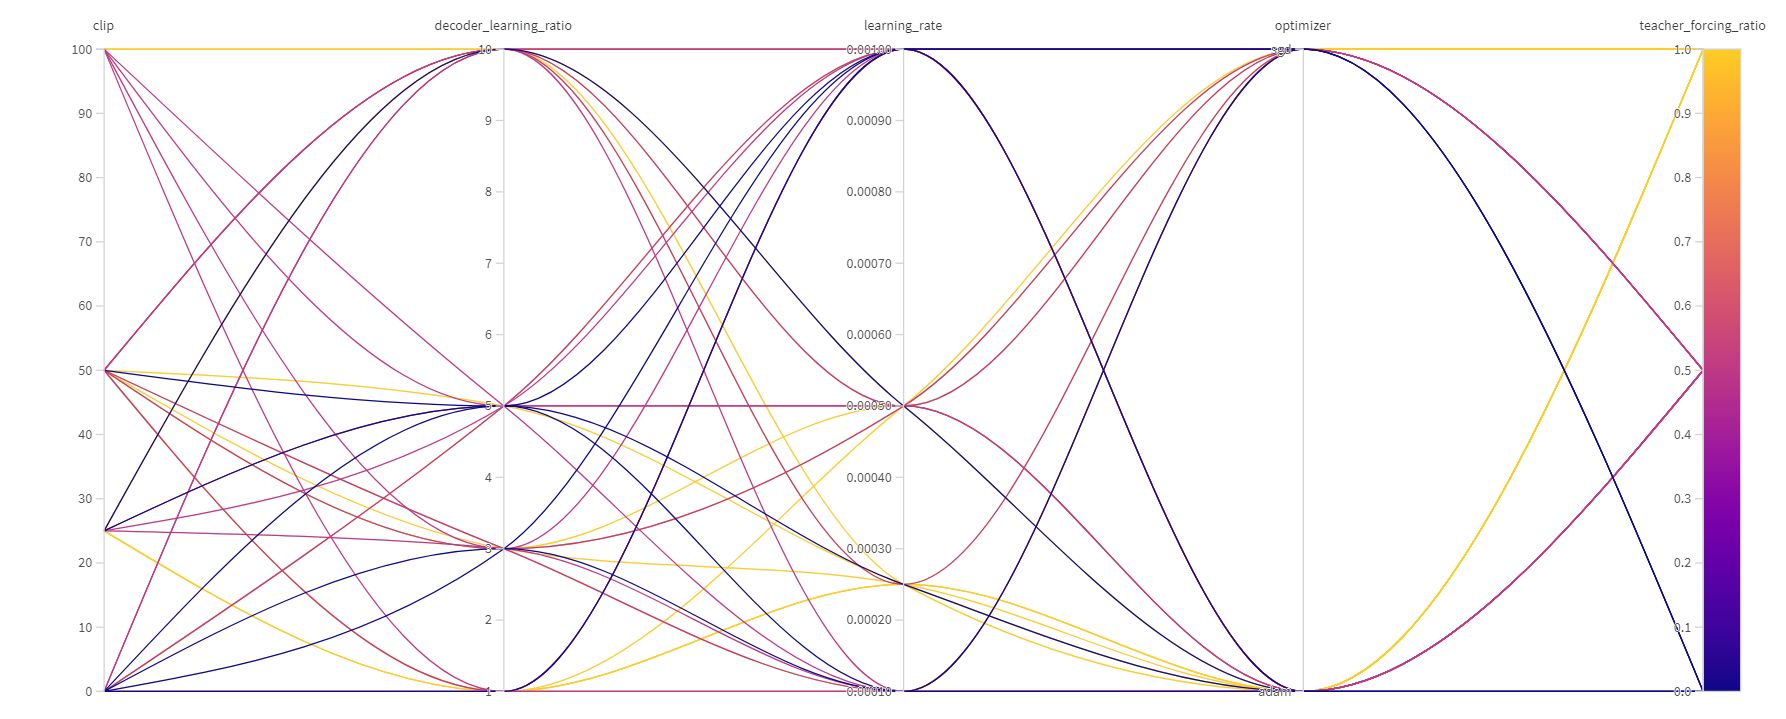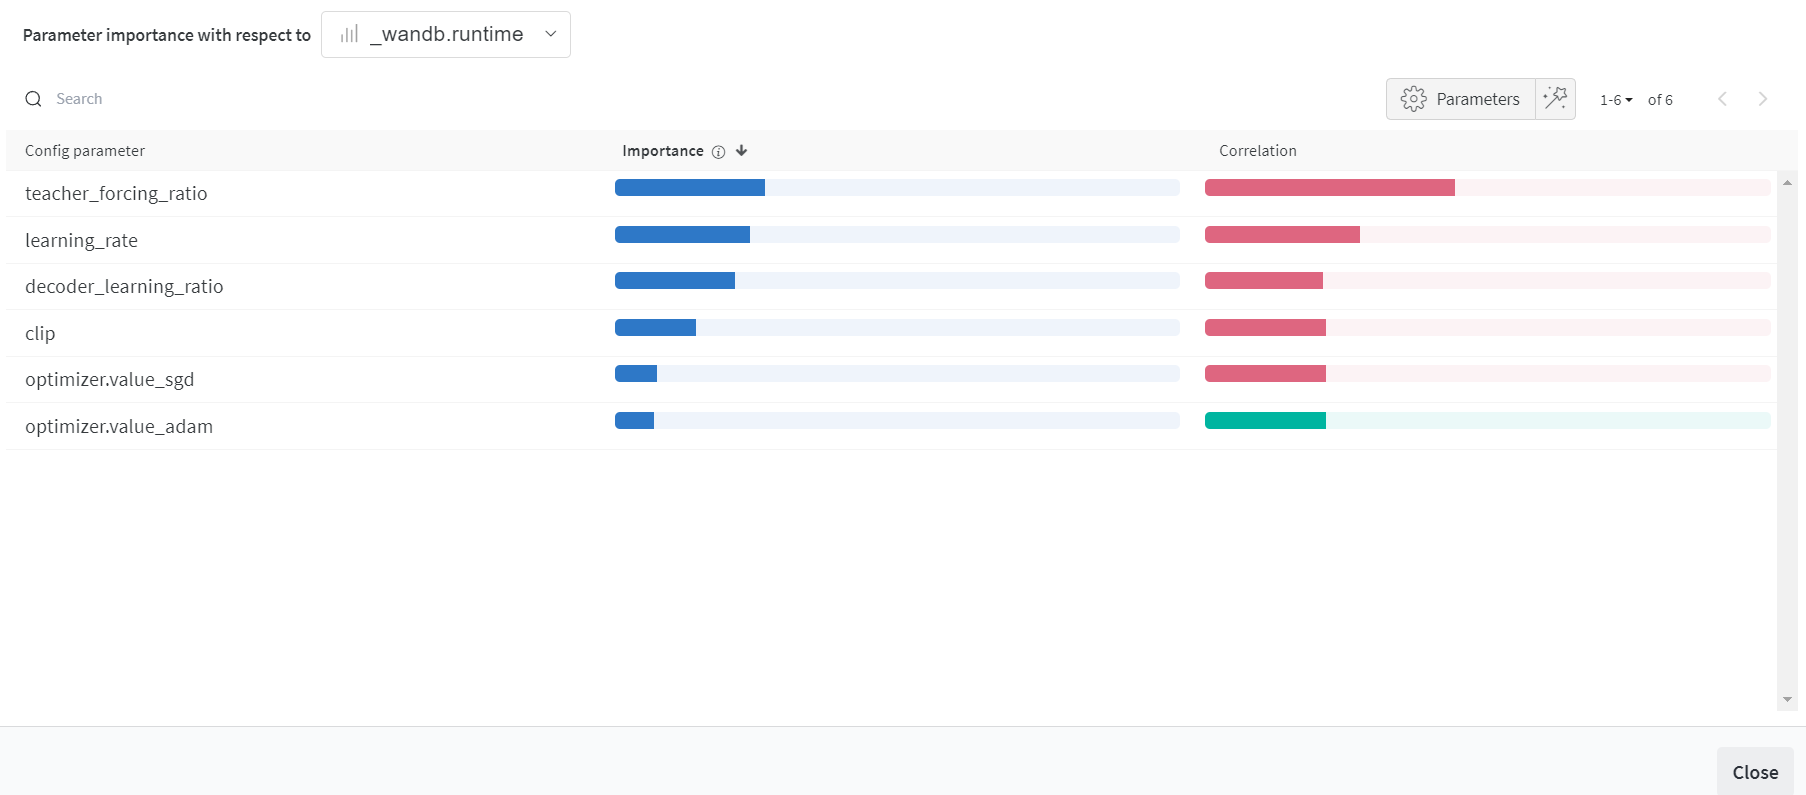

According to the parameter importance plot teacher_forcing_ratio plays the important factor and also has the highest correlation.

#Serving and Scaling the Chatbot Model

## Setup: Installing Required Libraries

Before we begin, let's install the necessary libraries. Run the following cells to install the required packages:

In [ ]:
!pip install torch torchvision torchaudio
!pip install flask
!pip install ray
!pip install torchx


If all libraries are installed correctly, you should see their versions printed without any errors.

In this notebook, we'll implement serving and scaling techniques for the chatbot model developed in Problem 2. We'll cover three main tasks:

1. Implementing a Flask API to serve the model
2. Using Ray for batch prediction
3. Leveraging TorchX and Ray for distributed inference

Let's get started!

## 1. Implementing a Flask API

In this section, we'll create a Flask server to serve our trained chatbot model.

### Step 1: Import necessary libraries

In [ ]:
# Import your model classes
from flask import Flask, request, jsonify
# Import your utility functions

In [ ]:
!pip install pyngrok

In [ ]:
!ngrok authtoken 2nV0N6tIsS99oJbIHjxsS1fUh61_2pokvrmj6nT9LKLEA6RRh

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok

### Step 2: Set up the Flask app and load the model

In [ ]:
# Load the trained model
import os
checkpoint_iter = 4000
loadFilename = os.path.join(save_dir, model_name, corpus_name,
                    '{}-{}_{}'.format(encoder_n_layers, decoder_n_layers, hidden_size),
                    '{}_checkpoint.tar'.format(checkpoint_iter))
model = torch.load(loadFilename, map_location=torch.device('cpu'))

<ipython-input-81-579faa96a3e2>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(loadFilename, map_location=torch.device('cpu'))


### Step 3: Implement the chat endpoint

In [ ]:
app = Flask(__name__)

@app.route('/chat', methods=['POST'])
def chat():
    try:
        if not request.is_json:
            return jsonify({'error': 'Invalid input. Please send JSON.'}), 400 # Error Handling
        data = request.json
        input_sentence = data['message']

        encoder.eval()
        decoder.eval()

        if not input_sentence:
            return jsonify({'error': 'No message provided.'}), 400 # Error handling

        input_sentence = normalizeString(input_sentence)
        # Evaluate sentence
        output_words = evaluate(encoder, decoder, searcher, voc, input_sentence)
        # Format and print response sentence
        output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]

        response = ' '.join(output_words)
        print(response)
        return jsonify({'response': response})
    except Exception as e:
        return jsonify({'error': str(e)}), 500

### Step 4: Run the Flask app

In [ ]:
# Create the tunnel with ngrok for port 5000
public_url = ngrok.connect(5000)
print("ngrok URL:", public_url)

ngrok URL: NgrokTunnel: "https://aa8c-34-143-225-16.ngrok-free.app" -> "http://localhost:5000"


In [ ]:
!pip install waitress

In [ ]:
from waitress import serve

# Start the Flask app with waitress
serve(app, host="0.0.0.0", port=500)

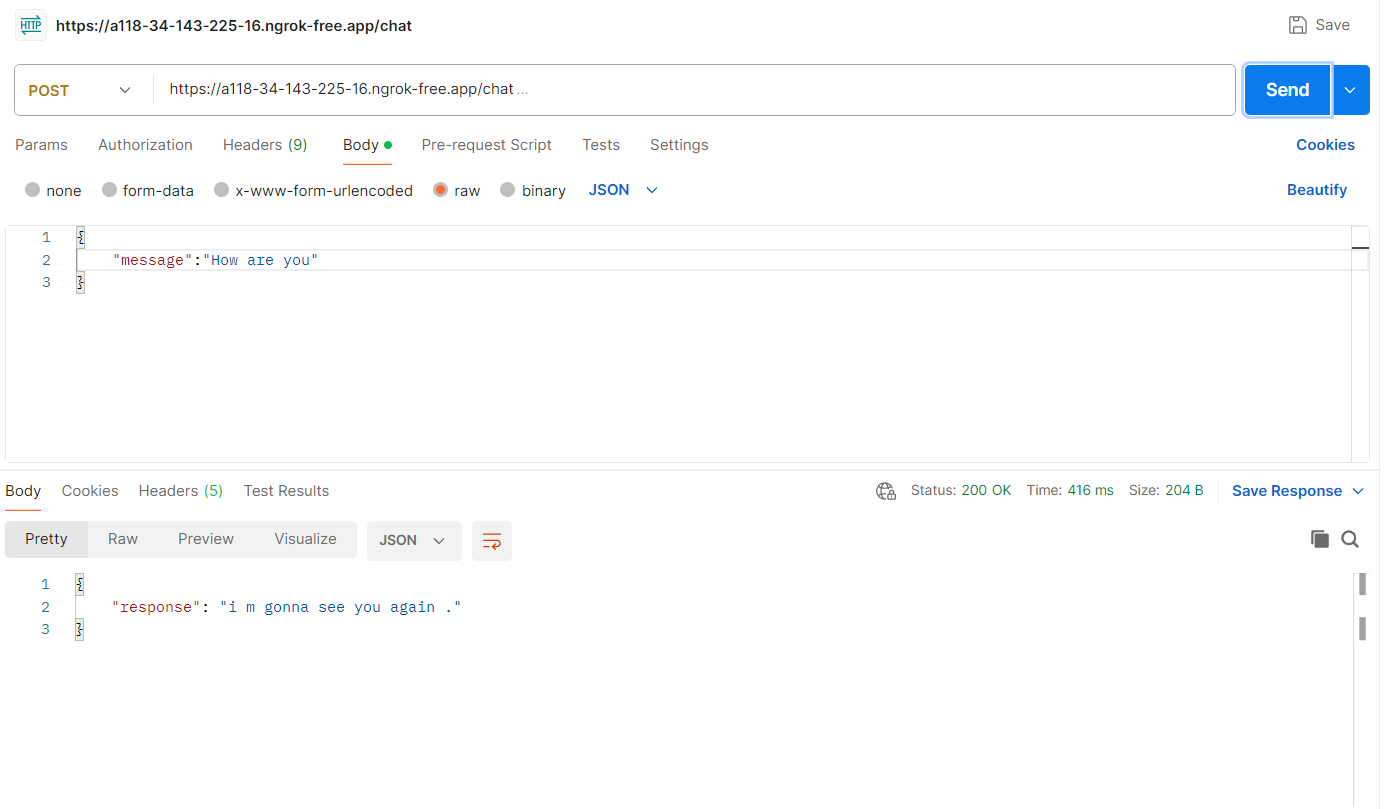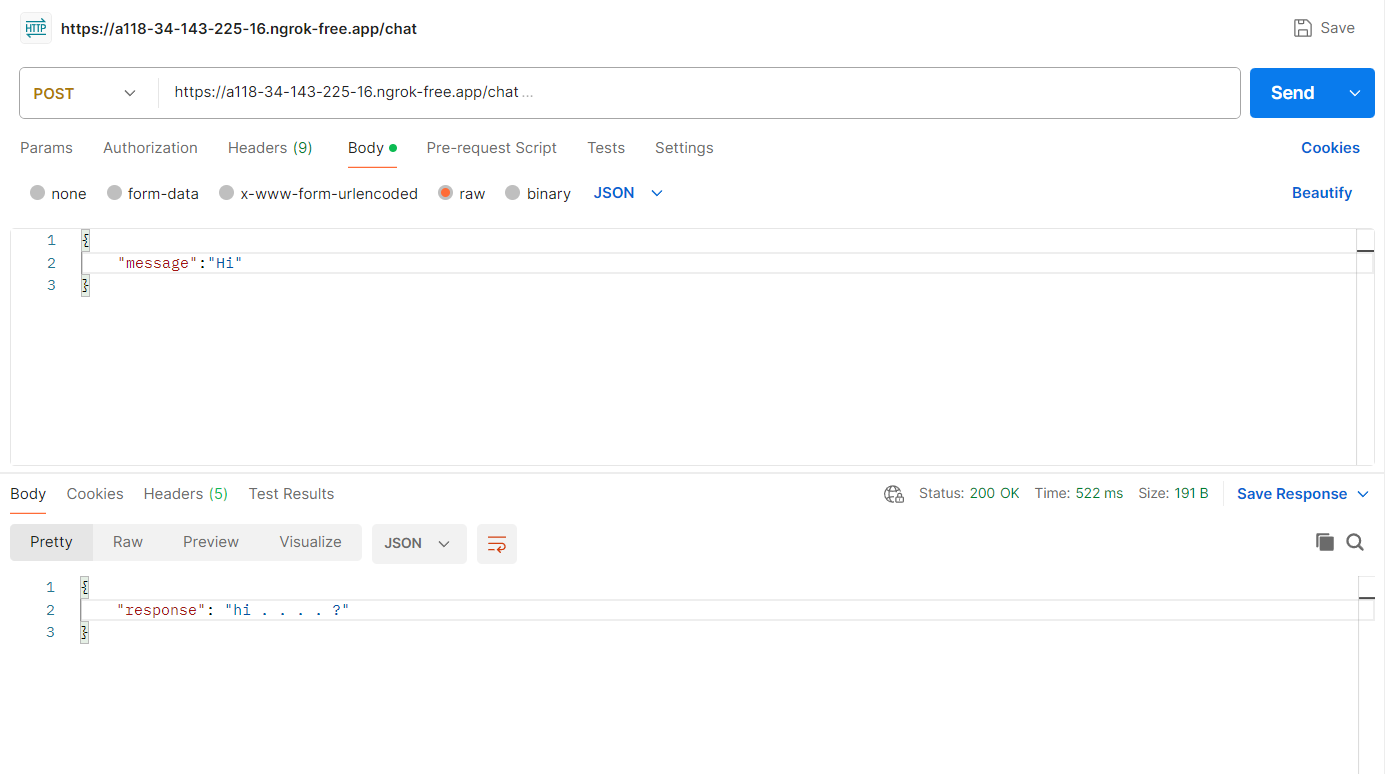

These are the screenshots of the app when called from Postman through the public URL

## 2. Implementing Batch Prediction with Ray

Now, let's use Ray to implement efficient batch prediction for our chatbot.

### Step 1: Import Ray and set up the environment

In [ ]:
import ray

### Step 2: Create a Ray actor for the chatbot model

In [ ]:
ray.shutdown()
ray.init()

@ray.remote(num_gpus=1)
class ChatbotModel:
    def __init__(self, encoder_ref, decoder_ref, searcher_ref, voc_ref):
        try:
            # Initialize device
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            print(f"Initializing ChatbotModel on device: {self.device}")

            # Load models from Ray object store
            print("Loading models from Ray object store...")
            self.encoder = encoder_ref
            self.decoder = decoder_ref
            self.searcher = searcher_ref
            self.voc = voc_ref

            # Move models to device
            print("Moving models to device...")
            self.encoder = self.encoder.to(self.device)
            self.decoder = self.decoder.to(self.device)
            self.searcher = self.searcher.to(self.device)

            # Set models to evaluation mode
            self.encoder.eval()
            self.decoder.eval()

            print("ChatbotModel initialization complete")

        except Exception as e:
            print(f"Error in ChatbotModel initialization: {str(e)}")
            raise

    def predict(self, input_sentence: str) -> str:
        response = ""
        try:
            print(f"\nProcessing input: '{input_sentence}'")

            # Input validation
            if not input_sentence:
                print("Empty input received")
                return response

            # Verify model devices
            print(f"Encoder device: {next(self.encoder.parameters()).device}")
            print(f"Decoder device: {next(self.decoder.parameters()).device}")
            print(f"Searcher device: {next(self.searcher.parameters()).device}")

            # Normalize input
            try:
                input_sentence = normalizeString(input_sentence)
                print(f"Normalized input: '{input_sentence}'")
            except Exception as e:
                print(f"Error in normalization: {str(e)}")
                raise

            # Generate response
            try:
                with torch.no_grad():
                    output_words = evaluate(
                        self.encoder,
                        self.decoder,
                        self.searcher,
                        self.voc,
                        input_sentence
                    )
                print(f"Raw output words: {output_words}")
            except Exception as e:
                print(f"Error in evaluate function: {str(e)}")
                raise

            output_words = [word for word in output_words if word not in ['EOS', 'PAD']]
            response = ' '.join(output_words)
            print(f"Final response: '{response}'")
            return response

        except Exception as e:
            error_msg = f"Error during prediction: {str(e)}"
            print(error_msg)
            print(f"Error type: {type(e)}")
            return error_msg

2024-10-19 22:16:38,801	INFO worker.py:1786 -- Started a local Ray instance.


In [ ]:
# Store in Ray object store
print("Storing models in Ray object store...")
encoder_ref = ray.put(encoder)
decoder_ref = ray.put(decoder)
searcher_ref = ray.put(searcher)
voc_ref = ray.put(voc)

for name, ref in [("encoder", encoder_ref), ("decoder", decoder_ref),
                         ("searcher", searcher_ref), ("voc", voc_ref)]:
            if not isinstance(ref, ray.ObjectRef):
                raise ValueError(f"{name}_ref is not a valid Ray ObjectRef")

print("Creating chatbot actor...")
chatbot_actor = ChatbotModel.remote(encoder_ref, decoder_ref, searcher_ref, voc_ref)

print("Verifying actor responsiveness...")
input_sentence = "Hello, how are you?"
response_future = chatbot_actor.predict.remote(input_sentence)
test_response = ray.get(response_future, timeout=10)
print(f"Actor test response: {test_response}")

Storing models in Ray object store...
Creating chatbot actor...
Verifying actor responsiveness...
(ChatbotModel pid=14243) Initializing ChatbotModel on device: cuda
(ChatbotModel pid=14243) Loading models from Ray object store...
(ChatbotModel pid=14243) Moving models to device...
(ChatbotModel pid=14243) ChatbotModel initialization complete
(ChatbotModel pid=14243) 
(ChatbotModel pid=14243) Processing input: 'Hello, how are you?'
(ChatbotModel pid=14243) Encoder device: cuda:0
(ChatbotModel pid=14243) Decoder device: cuda:0
(ChatbotModel pid=14243) Searcher device: cuda:0
(ChatbotModel pid=14243) Normalized input: 'hello how are you ?'
Actor test response: i m not gonna be back . .
(ChatbotModel pid=14243) Raw output words: ['i', 'm', 'not', 'gonna', 'be', 'back', '.', 'EOS', '.', 'EOS']
(ChatbotModel pid=14243) Final response: 'i m not gonna be back . .'


### Step 3: Implement batch prediction function

In [ ]:
def batch_predict(input_sentences, batch_size=3):
    results = []

    # Split input sentences into batches
    for i in range(0, len(input_sentences), batch_size):
        batch = input_sentences[i:i + batch_size]

        # Process batches in parallel using Ray
        futures = [chatbot_actor.predict.remote(sentence) for sentence in batch]

        # Fetch results
        batch_results = ray.get(futures)
        results.extend(batch_results)  # Add results to the main results list

    return results


### Step 4: Test the batch prediction

In [ ]:
# Example usage
# Give input sentences and test for results
input_sentences = ["Hello, how are you?", "What's the weather like?", "Tell me a joke.", "How do you do?", "What's your name?"]
responses = batch_predict(input_sentences)
print(responses)

['i m not gonna be back . .', 'you re not gonna be kidding . ?', 'i don t understand . . .', 'i don t know . . .', 'ahm . . . . .']


In [ ]:
# Example usage
# Give input sentences and test for results
# Example usage:

input_sentences = [
    "Hello, how are you?",
    "What is your name?",
    "Tell me a joke.",
    "How's the weather today?",
    "What can you do?",
    "What's the capital of France?",
    "Can you help me with my homework?",
    "What's your favorite color?",
    "Do you like music?",
    "Tell me something interesting.",
    "What are you doing?",
    "Are you an agent"
]

# Comparing performance
import time


class ChatbotModelNoRay:
    def __init__(self, encoder, decoder, searcher, voc):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.encoder = encoder
        self.decoder = decoder
        self.searcher = searcher
        self.voc = voc

    def predict(self, input_sentence: str) -> str:
        response = ""
        input_sentence = normalizeString(input_sentence)

        with torch.no_grad():
            output_words = evaluate(self.encoder, self.decoder, self.searcher, self.voc, input_sentence)
        output_words = [word for word in output_words if word not in ['EOS', 'PAD']]
        response = ' '.join(output_words)
        print(f"Final response: '{response}'")
        return response

chatbot = ChatbotModelNoRay(encoder, decoder, searcher, voc)
start = time.time()
for sent in input_sentences:
    batch_predictions = chatbot.predict(sent)

time_without_ray = time.time() - start
print(f"Time without using ray: {time_without_ray}")

start = time.time()
batch_predictions = batch_predict(input_sentences, batch_size=5)
time_with_ray = time.time() - start
print(f"Time with batch predictions using ray: {time_with_ray}")


Final response: 'i m not gonna be back . .'
Final response: 'edward . . . . .'
Final response: 'i don t understand . . .'
Final response: 'fine . . . . .'
Final response: 'i don t know . . .'
Final response: 'i don t know . . .'
Final response: 'i don t want to go . .'
Final response: 'i don t know . . .'
Final response: 'i don t know . . .'
Final response: 'what ? ? ? ? ?'
Final response: 'i m going to see you . .'
Final response: 'i m not gonna get him to get electrocuted .'
Time without using ray: 0.19267868995666504
(ChatbotModel pid=14243) 
(ChatbotModel pid=14243) Processing input: 'Hello, how are you?'
(ChatbotModel pid=14243) Encoder device: cuda:0
(ChatbotModel pid=14243) Decoder device: cuda:0
(ChatbotModel pid=14243) Searcher device: cuda:0
(ChatbotModel pid=14243) Normalized input: 'hello how are you ?'
(ChatbotModel pid=14243) Raw output words: ['i', 'm', 'not', 'gonna', 'be', 'back', '.', 'EOS', '.', 'EOS']
(ChatbotModel pid=14243) Final response: 'i m not gonna be back .